In [1]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.special import jv
from scipy.integrate import simps

Binning

In [2]:
# Transverse k bins
n_kt=512
# Parallel k bins
n_kp=512
# Radial bins
n_chi=50

Initialize cosmology

In [3]:
cosmo=ccl.Cosmology(Omega_c=0.26066676,
                    Omega_b=0.048974682,
                    h=0.6766,
                    sigma8=0.8102,
                    n_s=0.9665,
                    mass_function='tinker')
print(ccl.sigma8(cosmo))

0.8102000000000003


Read weighted COSMOS data.
Define function to estimate redshift distribution

In [4]:
cat=fits.open("data/cosmos_weights.fits")[1].data

def get_nz_from_photoz_bins(zp_code,zp_ini,zp_end,zt_edges,zt_nbins):
    # Select galaxies in photo-z bin                                                                     
    sel=(cat[zp_code]<=zp_end) & (cat[zp_code]>zp_ini)

    # Effective number of galaxies                                                                       
    ngal=len(cat) * np.sum(cat['weight'][sel])/np.sum(cat['weight'])

    # Make a normalized histogram                                                                        
    pz,z_bins=np.histogram(cat['PHOTOZ'][sel],          # 30-band photo-zs                               
                           bins=zt_nbins,               # Number of bins                                 
                           range=zt_edges,              # Range in z_true                                
                           weights=cat['weight'][sel],  # Color-space weights                            
                           density=True)
    nz=ngal*pz
    return nz, z_bins, ngal


Get $N(z)$ for $0.5<z_{\rm photo}<0.75$.

In [5]:
# dN/dz, z-bin edges, total number of galaxies
z0 = 0.5
zf = 0.75
a_fit = 0.63
b_fit = 0.095
c_fit = 2.7
dndz,zb,ngals=get_nz_from_photoz_bins(zp_code='pz_best_eab',
                                      zp_ini=z0,
                                      zp_end=zf,
                                      zt_edges=(0,2.),
                                      zt_nbins=n_chi)

Area (1.7 deg$^2$.) and disc radius 

In [6]:
area_deg2=1.7
area_rad2=area_deg2*(np.pi/180)**2
theta_rad=np.sqrt(area_rad2/np.pi)

$z$-dependent arrays

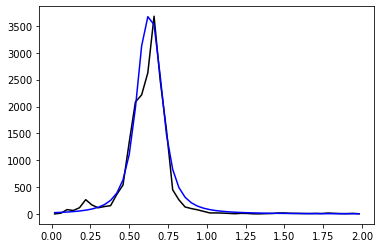

In [7]:
# Bin centers
zm=0.5*(zb[1:]+zb[:-1])
# Bin widths
dz=zb[1:]-zb[:-1]
# Number of galaxies in each bin
dn_noisy=dndz*dz
# Smooth fit to it
dn=np.amax(dn_noisy)*1./(1+(np.fabs(zm-a_fit)/b_fit)**c_fit)
# Comoving distance to bin edges
chis=ccl.comoving_radial_distance(cosmo,1./(1+zb))
# Mean comoving distance in each bin
chi_m=0.5*(chis[1:]+chis[:-1])
# Comoving distance width
dchi=chis[1:]-chis[:-1]
# Disc radii
R_m=theta_rad*chi_m
# Galaxy bias
b_m=0.95/ccl.growth_factor(cosmo,1./(1+zm))
# Growth rate (for RSDs)
f_m=ccl.growth_rate(cosmo,1./(1+zm))

plt.plot(zm,dn_noisy,'k-')
plt.plot(zm,dn,'b-')

${\bf k}$-dependent arrays

In [8]:
# Transverse modes
kt_arr=np.geomspace(0.00005,10.,n_kt)
# Parallel modes
kp_arr=np.geomspace(0.00005,10.,n_kp)
# Total wavenumber
k_arr=np.sqrt(kt_arr[None,:]**2+kp_arr[:,None]**2)

Array of power spectra at each bin centre and for all transverse and parallel modes.

We model it using the Kaiser formula:
$P_{gg}({\bf k})=\left(b_g+f\frac{k_\parallel^2}{k^2}\right)^2\,P_{mm}(k)$

In [9]:
pk_arr=np.array([(b+f*kp_arr[:,None]**2/k_arr**2)**2*
                 ccl.nonlin_matter_power(cosmo,k_arr.flatten(),a).reshape([n_kp,
                                                                           n_kt])
                 for a,b,f in zip(1./(1+zm),b_m,f_m)])

Window function for each bin in the COSMOS disc. The window function is:
    
$W(k_\parallel,k_\perp)=j_0(k_\parallel\Delta\chi/2)\,\frac{2 J_1(k_\perp R)}{k_\perp R}$

In [10]:
window=np.array([2*jv(1,kt_arr[None,:]*R)/(kt_arr[None,:]*R)*np.sin(0.5*kp_arr[:,None]*dc)/(0.5*kp_arr[:,None]*dc)
                 for R,dc in zip(R_m,dchi)])


The covariance matrix between two bins is given by:

${\rm Cov}_{ij}=\frac{N_i N_j}{2\pi^2} \int_0^\infty dk_\parallel \cos(k_\parallel(\chi_i-\chi_j))\int_0^\infty dk_\perp k_\perp W_i(k_\parallel,k_\perp)W_j(k_\parallel,k_\perp)P_{\bf gg}({\bf k})$

In [11]:
def covar(i,j):
    # Windows
    win_i=window[i]
    win_j=window[j]
    # Power spectrum
    pk_ij=np.sqrt(pk_arr[i]*pk_arr[j])
    # Cosine term
    dchi_ij=chi_m[i]-chi_m[j]
    cos_ij=np.cos(kp_arr*dchi_ij)
    # First integrand
    integrand_pt=(kt_arr[None,:]**2*win_i*win_j*pk_ij)/(2*np.pi**2)
    # Integrate over k_transverse
    integrand_p=simps(integrand_pt,axis=1,x=np.log(kt_arr))*cos_ij*kp_arr
    # Integrate over k_parallel
    integral=simps(integrand_p,x=np.log(kp_arr))
    return integral

Compute all covariance matrix elements

In [12]:
# Cosmic variance term
covmat_cv = np.array([[(ni+1)*(nj+1)*covar(i,j) 
                       for i,ni in enumerate(dn)]
                      for j,nj in enumerate(dn)])
# Shot noise term
covmat_sn = np.diag(dn+1)
# Total
covmat_tt = covmat_cv + covmat_sn

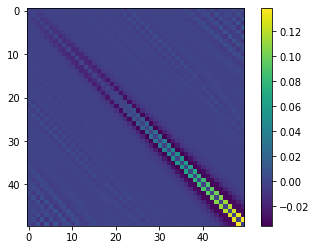

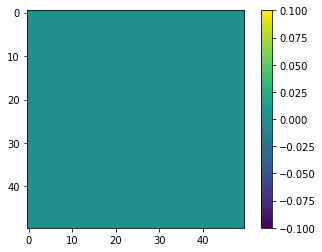

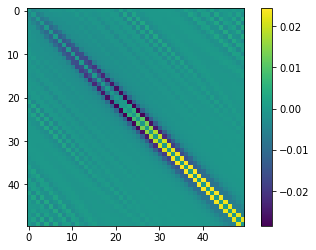

In [13]:
def plot_corrmat(covmat):
    plt.figure()
    plt.imshow(covmat/np.sqrt(np.diag(covmat)[None,:]*np.diag(covmat)[:,None])-np.diag(np.ones(n_chi)),interpolation='nearest')
    plt.colorbar()

plot_corrmat(covmat_cv)
plot_corrmat(covmat_sn)
plot_corrmat(covmat_tt)

Around the center of the bin, the uncertainties are around 20-30%

In [14]:
ibin=13
print(np.sqrt(covar(ibin,ibin)))
print(np.sqrt(covmat_cv[ibin,ibin])/dn[ibin])
print(np.sqrt(covmat_sn[ibin,ibin])/dn[ibin])
print(np.sqrt(covmat_tt[ibin,ibin])/dn[ibin])


0.28688630238698926
0.287031595688175
0.02251012130510052
0.2879129078114948


<ErrorbarContainer object of 3 artists>

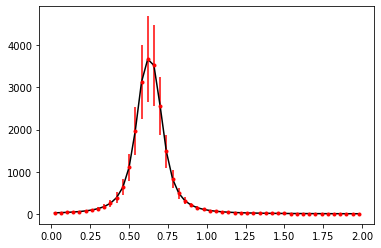

In [15]:
plt.plot(zm,dn,'k-')
plt.errorbar(zm,dn,
             yerr=np.sqrt(np.diag(covmat_tt)),
             fmt='r.')
#plt.plot(zm,dn,'b-')

Now we compute the posterior distribution for a redshift shift parameter $\delta z$. To do this, we brute-force evaluate the likelihood:

$p(\delta z)\propto\exp\left\{-\sum_{ij}[N(z_i)-N(z_i+\delta z)]\,{\rm Cov}^{-1}_{ij}[N(z_j)-N(z_j+\delta z)]\right\}$

In [16]:
from scipy.interpolate import interp1d

dn_f=interp1d(zm,dn,bounds_error=False,fill_value=0)
icov = np.linalg.inv(covmat_tt)

def dn_shifted(dz_shift):
    return dn_f(zm+dz_shift)

def p_shift(dz_shift):
    res=dn-dn_shifted(dz_shift)
    #chi2=np.sum(res**2/np.diag(covmat_tt))
    chi2=np.einsum('i,ij,j',res,icov,res)
    return np.exp(-0.5*chi2)

0.005109989344979479


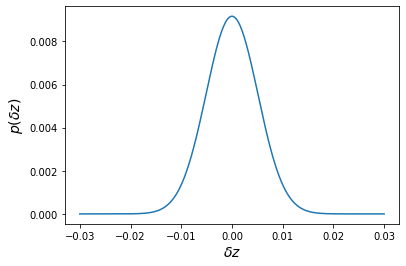

In [17]:
dz_shift_arr=np.linspace(-0.03,0.03,512)
p_dz_shift_arr=np.array([p_shift(-np.fabs(dzz)) for dzz in dz_shift_arr])
norm=np.sum(p_dz_shift_arr)
p_dz_shift_arr/=norm
print(np.sqrt(np.sum(p_dz_shift_arr*dz_shift_arr**2)))
plt.plot(dz_shift_arr,p_dz_shift_arr)
plt.xlabel('$\delta z$',fontsize=14)
plt.ylabel('$p(\delta z)$',fontsize=14)
plt.show()

Get from samples of $N(z)$

In [18]:
nsamples = 10000
dn_samples = np.random.multivariate_normal(dn, covmat_tt, size=nsamples)
z_mean = np.sum(dn_samples[:,:]*zm[None, :], axis=1)/np.sum(dn_samples, axis=1)
z_std = np.sqrt(np.sum(dn_samples[:,:]*(zm[None, :] - z_mean[:, None])**2, axis=1)/np.sum(dn_samples, axis=1))

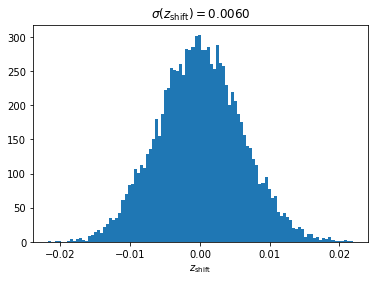

In [19]:
plt.figure()
plt.hist(z_mean-np.mean(z_mean), bins=100);
plt.xlabel(r'$z_{\rm shift}$')
plt.title(r'$\sigma(z_{\rm shift})=%.4lf$' % (np.std(z_mean)));

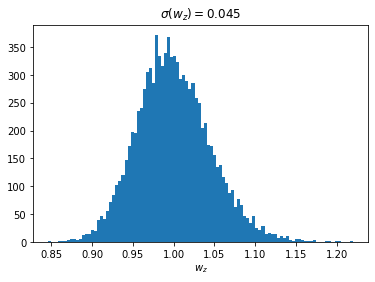

In [20]:
plt.figure()
plt.hist(z_std/np.mean(z_std), bins=100);
plt.xlabel(r'$w_z$')
plt.title(r'$\sigma(w_z)=%.3lf$' % (np.std(z_std)/np.mean(z_std)));

Summary of results (z0, zf, a, b, z, sigma(shift), sigma(width)):
- 0.15, 0.5, 0.38, 0.12, 3.5, 0.008, 0.05
- 0.5, 0.75, 0.63, 0.095, 2.7, 0.006, 0.045
- 0.75, 1.0, 0.88, 0.12, 3.5, 0.006, 0.04
- 1.0,  1.5, 1.20, 0.18, 3.0, 0.007, 0.03